In [ ]:
import sys
# !{sys.executable} -m pip install tldextract

<div style='text-align:center;'>
<h1>HopRank</h1>
<h2>Model Fitting</h2>
</div>

In [1]:
__author__ = "Lisette Espin-Noboa"
__copyright__ = "Copyright 2018, HopRank"
__credits__ = ["Florian Lemmerich", "Markus Strohmaier", "Simon Walk", "Mark Musen"]
__license__ = "GPL"
__version__ = "1.0.3"
__maintainer__ = "Lisette Espin-Noboa"
__email__ = "Lisette.Espin@gesis.org"
__status__ = "Developing"

########################################################################################
# Warnings
########################################################################################
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

<h2>Dependencies</h2>

In [2]:
########################################################################################
# System
########################################################################################
import os
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt 
from collections import Counter
from collections import defaultdict
from scipy.sparse import csr_matrix
import matplotlib.patches as patches
from joblib import Parallel, delayed
from palettable.tableau import Tableau_10, TableauMedium_10, Tableau_20
from palettable.cartocolors.qualitative import Vivid_7
    
########################################################################################
# Local Dependencies
########################################################################################
%reload_ext autoreload
%autoreload 2
from org.gesis.libs.bioportal.ontology import Ontology
from org.gesis.libs.bioportal.transition import Transition
from org.gesis.libs.bioportal.clickstream import NAVITYPES
from org.gesis.libs.bioportal.clickstream import load_clickstream
from org.gesis.libs.bioportal.clickstream import preprocess_clickstream
from org.gesis.libs.bioportal.clickstream import preprocess_sessions
from org.gesis.libs.bioportal.clickstream import clean_clickstream
from org.gesis.libs.bioportal.submission import get_submissions
from org.gesis.libs.utils import printf
from org.gesis.libs.utils import weighted_to_undirected
from org.gesis.libs.utils import to_symmetric
from org.gesis.libs.models.randomwalk import RandomWalk
from org.gesis.libs.models.markovchain import MarkovChain
from org.gesis.libs.models.hoprank import HopRank
from org.gesis.libs.models.preferential import PreferentialAttachment
from org.gesis.libs.models.gravitational import Gravitational

########################################################################################
# Plot's style
########################################################################################
# sns.set_context(context="paper", font_scale=1.8)
# sns.set_style("whitegrid")

<h2>Constants</h2>

In [3]:
SM = 'submission'
SUBMISSIONS_FN = '/bigdata/lespin/datasets/bioportal/submissions.json'

ON = 'ontology'
ONTOLOGY_ROOT = '/bigdata/lespin/datasets/bioportal/ontologies'
ONTOLOGY_GRAPH_OUTPUT = '/bigdata/lespin/bioportal/ontologies/graph'
ONTOLOGY_ADJACENCY_OUTPUT = '/bigdata/lespin/bioportal/ontologies/matrix'
ONTOLOGY_NODES_OUTPUT = '/bigdata/lespin/bioportal/ontologies/nodes'
ONTOLOGY_HOPS_OUTPUT = '/bigdata/lespin/bioportal/ontologies/hops'
ONTOLOGY_DISTANCE_OUTPUT = '/bigdata/lespin/bioportal/ontologies/distances'

CS = 'clickstream'
CS_FN = 'BP_webpage_requests_<YEAR><POSTFIX>.csv.bz2'
CLICKSTREAM_ROOT = '/bigdata/lespin/datasets/bioportal/clickstream/'
CLICKSTREAM_DF = '/bigdata/lespin/bioportal/clickstreams'

TR = 'transitions'
TRANS_GRAPH_OUTPUT = '/bigdata/lespin/bioportal/transitions/graph'
TRANS_ADJACENCY_OUTPUT = '/bigdata/lespin/bioportal/transitions/matrix'
TRANS_NODES_OUTPUT = '/bigdata/lespin/bioportal/transitions/nodes'
LCC_TRANS_GRAPH_OUTPUT = '/bigdata/lespin/bioportal/transitions_in_lcc/graph'
LCC_TRANS_ADJACENCY_OUTPUT = '/bigdata/lespin/bioportal/transitions_in_lcc/matrix'
LCC_TRANS_NODES_OUTPUT = '/bigdata/lespin/bioportal/transitions_in_lcc/nodes'
LCC_TRANS_MODEL_OUTPUT = '/bigdata/lespin/bioportal/transitions_in_lcc/modeling'

SU = 'summary'
LOG_OUTPUT = '/bigdata/lespin/bioportal/logs'
PLOTS_OUTPUT = '/bigdata/lespin/bioportal/plots'
SUMMARY_OUTPUT = '/bigdata/lespin/bioportal/summary'
YEAR = '2015'

LAG_BREAK_IN_MINUTES = 60
MIN_SESSION_LENGTH = 2
MIN_REQ = 1000
MIN_TRANSITIONS = 1000
MAXKHOPS = 30

LCC = True

<div style='text-align:center;'>
<h1>Functions</h1>
</div>

In [38]:
def __fit__(name, m, group):
    printf('{}...'.format(name))
    m.compute_loglikelihood()
    m.AIC()
    m.BIC()
    return {'ontology':group.ontology.unique()[0] if group is not None else None,
             'navitype':group.navitype.unique()[0] if group is not None else None,
             'model':name,
             'nparams':m.nparams,
             'nobservations':m.nobservations,
             'loglikelihood':m.loglikelihood,
             'aic':m.aic,
             'bic':m.bic}
    
def fit_random_walker(alpha, M, T, group):  
    m = RandomWalk(M,T,alpha)    
    name = 'RandomWalker {}'.format(m.alpha)
    return __fit__(name, m, group)

def fit_markov_chain(M, T, group):
    name = 'MarkovChain'
    m = MarkovChain(M,T) 
    return __fit__(name, m, group)

def fit_preferential_attachment(M, T, group):
    name = 'PreferentialAttachment'
    m = PreferentialAttachment(M,T)    
    return __fit__(name, m, group)

def fit_gravitational(M, T, distances, group):
    name = 'Gravitational'
    m = Gravitational(M,T,distances)    
    return __fit__(name, m, group)

def fit_hoprank(M, T, khops_fnc, betas, group, khops=None):
    name = 'HopRank'    
    m = HopRank(M,T,khops_fnc=khops_fnc,betas=betas, khops=khops)        
    return __fit__(name, m, group)

def short_name_models(df):
    tmp = df.copy()
    tmp.loc[tmp.query("model=='MarkovChain'").index,'model'] = 'MC'
    tmp.loc[tmp.query("model=='PreferentialAttachment'").index,'model'] = 'PA'
    tmp.loc[tmp.query("model=='Gravitational'").index,'model'] = 'Gr'
    tmp.loc[tmp.query("model.str.contains('RandomWalker') & nparams == 1").index,'model'] = 'RW E.'
    tmp.loc[:,'model'] = tmp.model.apply(lambda x: x.replace('RandomWalker','RW'))
    printf(tmp.model.unique())
    return tmp

def plot_bic_values(df, col_wrap=None, col_order=None, x_order=None, evaluation='bic', fn=None, ybest=0.01):
    sns.set_context(context="paper", font_scale=1.5)
    sns.set_style("whitegrid")
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8, 
                            'xtick.color': 'black', 'ytick.color': 'black',
                           'axes.edgecolor': 'black'})
    
    tmp = df.copy()
    
    fg = sns.catplot(data=tmp,
                kind='bar',
                x='model',
                y=evaluation,
                col='navitype',
                col_wrap= col_wrap,
                col_order=col_order,
                order=x_order,
                height=5 if col_wrap is None else 3,
                aspect=0.7 if col_wrap is None else 1,
                sharex=True,
                sharey=True,
            )

    _ = fg.set_titles(row_template = '{row_name}', col_template = '{col_name}')

    for i,ax in enumerate(fg.axes.flatten()):
        _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        
        _ = ax.set_label('')
        
        if (col_wrap is None and i == 0) or (col_wrap is not None and i % int(round(len(col_order)/2.)) == 0):
            _ = ax.set_ylabel('BIC')
    
        if col_wrap is not None and i < len(col_order)-col_wrap:
            _ = ax.set_xlabel('')
           
        ### SELECTING BEST MODEL (LOWEST BIC)
        try:     
            nt = col_order[i]
            gax = tmp.query('navitype==@nt').copy()[['model','bic']].set_index('model').reindex(x_order).reset_index()
            gax.bic = gax.bic.astype(np.float64)            
            x = gax.bic.idxmin()
            y = gax.loc[x,'bic']            
            del(gax)
            rect = patches.Rectangle((x-0.4,ybest),0.8,y,linewidth=3,edgecolor='black',facecolor='none')
            _ = ax.add_patch(rect)
        except:
            pass
        
        
        ### SETTING TO LOG SCALE
        try:
            _ = ax.set_ylim((max(tmp.bic.min()-10,0.01),tmp.bic.max()+1))
            _ = ax.set_yscale('log')
        except:
            pass
        
    _ = plt.subplots_adjust(hspace=0.0, wspace=0.0)
    _ = plt.tight_layout()
    
    if fn is not None:
        _ = plt.savefig(fn, bbox_inches='tight')
        printf('{} saved!'.format(fn)) 
        
    _ = plt.show()
    _ = plt.clf()
 
    
def plot_model_selection(df, navitypes_order, model_order, fn, evaluation='bic', verbose=False):
    sns.set_context(context="paper", font_scale=1.5)
    sns.set_style("whitegrid")
    sorted_ontos = ['SNOMEDCT','CPT','MEDDRA','NDFRT','LOINC','ICD9CM',"WHO-ART","MESH",'ICD10','CHMO','HL7','OMIM']
    
    tmp = df.copy()
    tmp = short_name_models(df)
    sorted_ontos = [o for o in sorted_ontos if o in tmp.ontology.unique()]
    
    # Selecting the model with lowest bic
    tmp.fillna(99999999999999,inplace=True)
    tmp = tmp[tmp[evaluation].isin(tmp.groupby(['ontology','navitype'])[evaluation].min().values)]

    # Creating list of models (and adding '-' when no data is available)
    methods = [m for m in model_order if m in tmp.model.unique().tolist()]
    methods.append("-")
    if verbose:
        printf(methods)

    # Creating pivoted table: model vs ontology
    tmp = pd.pivot_table(tmp,'model', 'ontology', 'navitype', aggfunc=np.min) 
    tmp = tmp[navitypes_order]
    tmp = tmp.reset_index(0).reset_index(drop=True)
    tmp.set_index('ontology',inplace=True,drop=True)
    tmp.fillna('-',inplace=True)
    tmp = tmp.reindex(index = sorted_ontos)
    if verbose:
        print(tmp)

    # Setting model categories to indexes from list of models
    try: tmp.ALL = tmp.apply(lambda r: methods.index(r.ALL), axis=1)
    except: pass

    try: tmp.DE = tmp.apply(lambda r: methods.index(r.DE), axis=1)
    except: pass

    try: tmp.DC = tmp.apply(lambda r: methods.index(r.DC), axis=1)
    except: pass

    try: tmp.DU = tmp.apply(lambda r: methods.index(r.DU), axis=1)
    except: pass

    try: tmp.EX = tmp.apply(lambda r: methods.index(r.EX), axis=1)
    except: pass

    try: tmp.EL = tmp.apply(lambda r: methods.index(r.EL), axis=1)
    except: pass

    try: tmp.ES = tmp.apply(lambda r: methods.index(r.ES), axis=1)
    except: pass

    try: tmp.LS = tmp.apply(lambda r: methods.index(r.LS), axis=1)
    except: pass

    try: tmp.HS = tmp.apply(lambda r: methods.index(r.HS), axis=1)
    except: pass

    if verbose:
        print(tmp)
    
    # Plotting categorical heatmap
    values = list(sorted(set(tmp.values.flatten())))
    colors = Tableau_20.mpl_colors[:max(values)+1]
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    ax = sns.heatmap(tmp[navitypes_order], 
                     cmap=colors, 
                     cbar=False, 
                     ax=ax,
                     linewidths=1.,
                     linecolor='white'
                    )
#     ax.set_ylabel('')
#     ax.set_xlabel('')

    # Setting legend
    lines = [ plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=colors[i], label="{}".format(methods[i]) )[0]  
             for i in values ]
    plt.legend(handles=lines, loc='best', mode='expand',ncol=1, bbox_to_anchor=(1.0, -0.15, 0.55, 1.0), 
               handlelength=2.0,
               handletextpad=0.1,
               frameon=False,
              )

#     _ = plt.subplots_adjust(hspace=0.0, wspace=0.0)
#     _ = plt.tight_layout()
    
    # saving figure as pdf
    if fn is not None:
        plt.savefig(fn, bbox_inches='tight')
    plt.show()
    plt.close()

<div style='text-align:center;'>
<h1>Model Selection</h1>
</div>

In [39]:
columns = ['ontology','navitype','model','nparams','nobservations','loglikelihood','aic','bic']
fn_results = os.path.join(LCC_TRANS_MODEL_OUTPUT,'lcc_model_{}_final.csv'.format(YEAR))
if os.path.exists(fn_results):
    results_model = pd.read_csv(fn_results)
    printf('{} loaded!'.format(fn_results))
else:
    results_model = pd.DataFrame(columns=columns)

    # Updating (adding new ones)
    print('loading submissions...')
    submissions_dict = get_submissions(SUBMISSIONS_FN)

    print('loading k-hop overlaps...')
    fn = os.path.join(SUMMARY_OUTPUT,'lcc_summary_overlaps_{}.{}'.format(YEAR,'csv'))
    df_overlap = pd.read_csv(fn, index_col=None)

    for onto_name, df in df_overlap.groupby('ontology'):

        printf("=== {} ===".format(onto_name))

        if onto_name in results_model.ontology.unique():
            printf('{} already exists. Skip.'.format(onto_name))
            continue

        submission = submissions_dict[onto_name][YEAR]
        onto = Ontology(name=onto_name, year=YEAR, submission_id=submission['submissionId'], root_folder=ONTOLOGY_ROOT)
        onto.load_adjacency(path=ONTOLOGY_ADJACENCY_OUTPUT, lcc=True)
        onto.set_lcc(LCC)
        onto.set_path_khop(ONTOLOGY_HOPS_OUTPUT)
        distances = onto.create_distance_matrix(path=ONTOLOGY_DISTANCE_OUTPUT, hopspath=None, lcc=LCC)

        tmp = df.copy()
        tmp.rename(columns={'%transitions':'beta'}, inplace=True)
        for navitype, group in tmp.groupby('navitype'):

            fn_preliminar = os.path.join(LCC_TRANS_MODEL_OUTPUT,'lcc_model_{}_{}_{}.csv'.format(YEAR,onto_name,navitype))
            if os.path.exists(fn_preliminar):
                results_model = results_model.append(pd.read_csv(fn_preliminar, index_col=None), ignore_index=True)
                printf('{} loaded!'.format(navitype))
            else:
                printf('{} computing...'.format(navitype))
                betas = group.query("khop <= diameter")[['khop','beta']].set_index('khop')  

                if betas.beta.sum() == 0:
                    printf("{}-{}: nothing to compute. skip!".format(onto_name,navitype))
                    continue

                betas = betas.append(pd.DataFrame({'beta':[0]},index=[0])) + 0.001 # plus 1?
                betas = betas*100 / betas.sum()
                betas.sort_index(inplace=True)
                print(betas)

                cs = Transition(onto_name, navitype, YEAR)            
                cs.load_adjacency(path=LCC_TRANS_ADJACENCY_OUTPUT)

                preliminar_model = pd.DataFrame(columns=columns)

                model = fit_random_walker(0.0, onto.get_adjacency_matrix(lcc=LCC),cs.get_adjacency_matrix(), group)
                preliminar_model = preliminar_model.append(model, ignore_index=True)

                model = fit_random_walker(0.85, onto.get_adjacency_matrix(lcc=LCC),cs.get_adjacency_matrix(), group)
                preliminar_model = preliminar_model.append(model, ignore_index=True)

                model = fit_random_walker(1.0, onto.get_adjacency_matrix(lcc=LCC),cs.get_adjacency_matrix(), group)
                preliminar_model = preliminar_model.append(model, ignore_index=True)

                model = fit_random_walker(None, onto.get_adjacency_matrix(lcc=LCC),cs.get_adjacency_matrix(), group)
                preliminar_model = preliminar_model.append(model, ignore_index=True)

                model = fit_markov_chain(onto.get_adjacency_matrix(lcc=LCC),cs.get_adjacency_matrix(), group)
                preliminar_model = preliminar_model.append(model, ignore_index=True)

                model = fit_preferential_attachment(onto.get_adjacency_matrix(lcc=LCC),cs.get_adjacency_matrix(), group)
                preliminar_model = preliminar_model.append(model, ignore_index=True)

                model = fit_hoprank(onto.get_adjacency_matrix(lcc=LCC),cs.get_adjacency_matrix(), onto.get_khop, betas, group)
                preliminar_model = preliminar_model.append(model, ignore_index=True)

                model = fit_gravitational(onto.get_adjacency_matrix(lcc=LCC),cs.get_adjacency_matrix(), distances, group)
                preliminar_model = preliminar_model.append(model, ignore_index=True)

                preliminar_model.to_csv(fn_preliminar, index=None)
                results_model = results_model.append(preliminar_model, ignore_index=True)

            try: del(preliminar_model)
            except: pass

            try: del(cs)
            except: pass

        del(onto)

    results_model.to_csv(fn_results, index=None) 
    printf('{} saved!'.format(fn_results))
    
    

2019-02-25 11:38:51	/bigdata/lespin/bioportal/transitions_in_lcc/modeling/lcc_model_2015_final.csv loaded!


In [40]:
results_model

,ontology,navitype,model,nparams,nobservations,loglikelihood,aic,bic
0,CHMO,ALL,RandomWalker 0.0,0,1423,-11375.881766,2.275176e+04,2.275176e+04
1,CHMO,ALL,RandomWalker 0.85,0,1423,-9708.524048,1.941705e+04,1.941705e+04
2,CHMO,ALL,RandomWalker 1.0,0,1423,-27163.362287,5.432672e+04,5.432672e+04
3,CHMO,ALL,RandomWalker 0.36,1,1423,-8937.015635,1.787603e+04,1.788129e+04
4,CHMO,ALL,MarkovChain,8779368,1423,-798.076174,1.756033e+07,6.374440e+07
5,CHMO,ALL,PreferentialAttachment,0,1423,-11374.642735,2.274929e+04,2.274929e+04
6,CHMO,ALL,Gravitational,0,1423,-10890.778936,2.178156e+04,2.178156e+04
7,CHMO,ALL,HopRank,23,1423,-6226.507529,1.249980e+04,1.262001e+04
8,CHMO,DC,RandomWalker 0.0,0,43,-343.754684,6.875094e+02,6.875094e+02
9,CHMO,DC,RandomWalker 0.85,0,43,-268.946902,5.378938e+02,5.378938e+02


In [17]:
results_model.query("ontology == 'CHMO' & navitype=='LS'")

,ontology,navitype,model,nparams,nobservations,loglikelihood,aic,bic
40,CHMO,LS,RandomWalker 0.0,0,126,-1007.281168,2.014562e+03,2.014562e+03
41,CHMO,LS,RandomWalker 0.85,0,126,-1138.494593,2.276989e+03,2.276989e+03
42,CHMO,LS,RandomWalker 1.0,0,126,-2722.826512,5.445653e+03,5.445653e+03
43,CHMO,LS,RandomWalker 0.02,1,126,-1004.743165,2.011519e+03,2.014323e+03
44,CHMO,LS,MarkovChain,8779368,126,-46.977660,1.755883e+07,4.245959e+07
45,CHMO,LS,PreferentialAttachment,0,126,-1007.220170,2.014440e+03,2.014440e+03
46,CHMO,LS,Gravitational,0,126,-1002.086781,2.004174e+03,2.004174e+03
47,CHMO,LS,HopRank,23,126,-974.797810,1.995596e+03,2.060830e+03


<h2>Plotting BIC per ontology and navitype</h2>

In [ ]:
navitypes_order = ['DE','DC','DU','EX','EL','ES','LS']
model_order = ['RW 0.0','RW 0.85','RW 1.0','RW E.','MC','PA','Gr','HopRank']

for onto_name, onto_model in results_model.groupby('ontology'):
    tmp = short_name_models(onto_model)
    
    fn = os.path.join(PLOTS_OUTPUT, '_lcc_summary_model_selection_bic_{}_{}.pdf'.format(onto_name,YEAR))
    _ = plot_bic_values(tmp, None, navitypes_order, model_order, 'bic', fn)
    
    fn = os.path.join(PLOTS_OUTPUT, 'lcc_summary_model_selection_bic_{}_{}.pdf'.format(onto_name,YEAR))
    _ = plot_bic_values(tmp, 4, navitypes_order+['ALL'], model_order, 'bic', fn)
    

2019-02-25 12:12:22	['RW 0.0' 'RW 0.85' 'RW 1.0' 'RW E.' 'MC' 'PA' 'Gr' 'HopRank']
2019-02-25 12:12:25	/bigdata/lespin/bioportal/plots/lcc_summary_model_selection_bic_MEDDRA_2015.pdf saved!


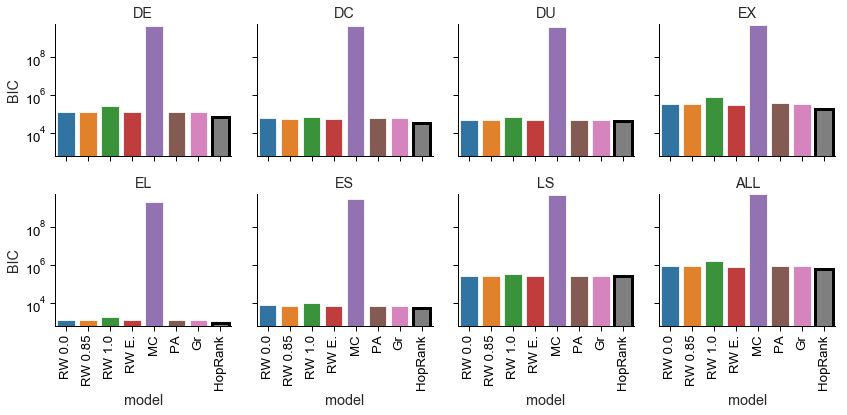

<Figure size 432x288 with 0 Axes>

In [44]:
navitypes_order = ['DE','DC','DU','EX','EL','ES','LS']
model_order = ['RW 0.0','RW 0.85','RW 1.0','RW E.','MC','PA','Gr','HopRank']

onto_name = 'MEDDRA'
tmp = short_name_models(results_model.query("ontology==@onto_name"))
fn = os.path.join(PLOTS_OUTPUT, 'lcc_summary_model_selection_bic_{}_{}.pdf'.format(onto_name,YEAR))
_ = plot_bic_values(tmp, 4, navitypes_order+['ALL'], model_order, 'bic', fn, ybest=-240)

<h2>Plotting Model Selection</h2>

In [ ]:
fn = os.path.join(PLOTS_OUTPUT, 'lcc_summary_model_selection_min_bic_{}.pdf'.format(YEAR))
plot_model_selection(results_model.query("nobservations>1"), navitypes_order, model_order, fn, evaluation='bic', verbose=False)

<div style='text-align:center;'>
<h1>Toy-Example</h1>
</div>

In [33]:
from scipy.sparse import lil_matrix
from scipy.sparse import csr_matrix

def hop_counts(structure):
    hops = lil_matrix(structure.shape, dtype=np.int8)
    previous_hops = None
    
    hop = 1
    structure.setdiag(0)
    m = structure.copy().tocsr()

    hops = np.multiply(m,hop)
    
    while m.sum() > 0:
        
        if previous_hops is None:
            previous_hops = m.copy()
        else:
            previous_hops += m.copy()
        
        m = structure.copy()
        for h in range(hop):
            m = lil_matrix(m.dot(structure))
            m = (m>0).astype(np.int8)
            
        m.setdiag(0)
        m -= previous_hops
        m = (m>0).astype(np.int8)
        m.setdiag(0)
        m.eliminate_zeros()
        
        hop += 1
        hops += np.multiply(m,hop)

    hops.setdiag(0) 
    return hops

def hop_betas(transitions, hops):  
    maxhops = int(hops.tocsr().max())     
    total = transitions.sum() + maxhops + 1 #smoothing
    betas = np.zeros(maxhops + 1)
    counts = np.zeros(maxhops + 1)
    
    for hop in range(maxhops+1):
        if hop == 0:
            counts[hop] = 1 # for selfloops
        else:
            transitions_in_hop = np.any(hops==hop).astype(np.int8).multiply(transitions)
            counts[hop] = (transitions_in_hop.sum()) + 1
        betas[hop] = counts[hop] / total
    
    betas = pd.DataFrame(betas,index=np.arange(betas.shape[0]))
    betas.rename(columns={0:'beta'}, inplace=True)
    return betas, counts

In [34]:
### STRUCTURE
G=nx.DiGraph()
G.add_edge('b','a')
G.add_edge('c','a')
G.add_edge('d','b')
G.add_edge('e','b')
G.add_edge('f','c')
G.add_edge('g','c')


### TRANSITIONS (HOPRANK)
H=nx.DiGraph()
H.add_edge('b','d',weight=1)   # 1hop
H.add_edge('d','e',weight=100) # 2hop
H.add_edge('e','g',weight=15)  # 4hop


### Adjacency matrices
M = nx.adjacency_matrix(G.to_undirected(),['a','b','c','d','e','f','g']).tocsr()
T = nx.adjacency_matrix(H,['a','b','c','d','e','f','g']).tocsr()
MT = to_symmetric(T,binary=False)

### hops
khops = hop_counts(M)
betas, counts = hop_betas(T, khops)

### Modeling
model = fit_random_walker(0.0, M, T, None)
synthetic_results = pd.DataFrame(model,index=[0])

model = fit_random_walker(0.85, M, T, None)
synthetic_results = synthetic_results.append(model, ignore_index=True)

model = fit_random_walker(1.0, M, T, None)
synthetic_results = synthetic_results.append(model, ignore_index=True)

model = fit_random_walker(None, M, T, None)
synthetic_results = synthetic_results.append(model, ignore_index=True)

model = fit_markov_chain(M, T, None)
synthetic_results = synthetic_results.append(model, ignore_index=True)

model = fit_preferential_attachment(M, T, None)
synthetic_results = synthetic_results.append(model, ignore_index=True)

model = fit_gravitational(M, T, khops, None)
synthetic_results = synthetic_results.append(model, ignore_index=True)

model = fit_hoprank(M, T, None, betas, None, khops=khops)
synthetic_results = synthetic_results.append(model, ignore_index=True)

2019-02-25 11:38:01	RandomWalker 0.0...
2019-02-25 11:38:01	RandomWalker 0.85...
2019-02-25 11:38:01	RandomWalker 1.0...
2019-02-25 11:38:01	Empirical alpha (damping factor): 0.01
2019-02-25 11:38:01	RandomWalker 0.01...
2019-02-25 11:38:01	MarkovChain...
2019-02-25 11:38:01	PreferentialAttachment...
2019-02-25 11:38:01	Gravitational...
2019-02-25 11:38:01	HopRank...


/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [35]:
synthetic_results

,aic,bic,loglikelihood,model,navitype,nobservations,nparams,ontology
0,451.451155,451.451155,-225.725577,RandomWalker 0.0,None,116,0,None
1,886.273380,886.273380,-443.136690,RandomWalker 0.85,None,116,0,None
2,5745.702254,5745.702254,-2872.851127,RandomWalker 1.0,None,116,0,None
3,455.771329,458.489832,-226.868121,RandomWalker 0.01,None,116,1,None
4,70.000000,166.375657,0.000000,MarkovChain,None,116,35,None
5,522.299697,522.299697,-261.149849,PreferentialAttachment,None,116,0,None
6,513.545851,513.545851,-256.772926,Gravitational,None,116,0,None
7,274.888491,288.656442,-132.444246,HopRank,None,116,5,None


2019-02-25 11:38:15	['RW 0.0' 'RW 0.85' 'RW 1.0' 'RW E.' 'MC' 'PA' 'Gr' 'HopRank']
4 166.37565668872276


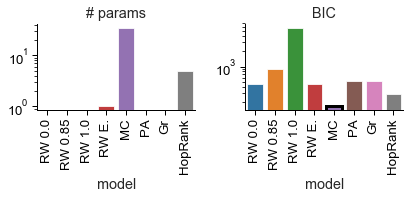

In [37]:
sns.set_context(context="paper", font_scale=1.5)
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8, 
                            'xtick.color': 'black', 'ytick.color': 'black',
                           'axes.edgecolor': 'black'})

model_order = ['RW 0.0','RW 0.85','RW 1.0','RW E.','MC','PA','Gr','HopRank']

tmp = short_name_models(synthetic_results)

tmp1 = tmp[['model','nparams']].copy()
tmp2 = tmp[['model','bic']].copy()
tmp1.loc[:,'data'] = '# params'
tmp2.loc[:,'data'] = 'BIC'
tmp1.rename(columns={'nparams':'value'}, inplace=True)
tmp2.rename(columns={'bic':'value'}, inplace=True)
tmp = pd.concat([tmp1,tmp2],ignore_index=True,axis='index')

fg = sns.catplot(data=tmp,
           x='model',
           y='value',
           col='data',
           kind='bar',
           order=model_order,
           sharey=False,
           height=3,
           aspect=1,
        )

# height=5 if col_wrap is None else 3,
# aspect=0.7 if col_wrap is None else 1,
    
_ = fg.set_titles(row_template = '{row_name}', col_template = '{col_name}')
for i,ax in enumerate(fg.axes.flatten()):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yscale('log')
    ax.set_ylabel('')

try:
    gax = tmp.query("data=='BIC'").copy()[['model','value']].set_index('model').reindex(model_order).reset_index()
    x = gax.value.idxmin()
    y = gax.loc[x,'value']
    print(x,y)
    
    rect = patches.Rectangle((x-0.4,0.01),0.8,y,linewidth=3,edgecolor='black',facecolor='none')
    _ = ax.add_patch(rect)
except:
    pass
    
_ = plt.subplots_adjust(hspace=0.1, wspace=0.1)
_ = plt.tight_layout()

fn = os.path.join(PLOTS_OUTPUT, 'lcc_summary_model_selection_min_bic_synthetic.pdf')
plt.savefig(fn, bbox_inches='tight')
plt.show()
plt.close()

In [9]:
m = HopRank(M,T,khops_fnc=None,betas=betas, khops=khops)        
m

In [10]:
tmp = m.compute_loglikelihood().toarray()


In [11]:
print(tmp.round(3))

[[0.001 0.011 0.011 0.244 0.244 0.244 0.244]
 [0.008 0.001 0.963 0.008 0.008 0.006 0.006]
 [0.008 0.963 0.001 0.006 0.006 0.008 0.008]
 [0.419 0.018 0.009 0.001 0.419 0.067 0.067]
 [0.419 0.018 0.009 0.419 0.001 0.067 0.067]
 [0.419 0.009 0.018 0.067 0.067 0.001 0.419]
 [0.419 0.009 0.018 0.067 0.067 0.419 0.001]]


In [12]:
betas.round(3)

,beta
0,0.008
1,0.017
2,0.835
3,0.008
4,0.132


In [13]:
khops.toarray()

array([[0, 1, 1, 2, 2, 2, 2],
       [1, 0, 2, 1, 1, 3, 3],
       [1, 2, 0, 3, 3, 1, 1],
       [2, 1, 3, 0, 2, 4, 4],
       [2, 1, 3, 2, 0, 4, 4],
       [2, 3, 1, 4, 4, 0, 2],
       [2, 3, 1, 4, 4, 2, 0]], dtype=int64)